# Collaborative filtering explained using Amazon Reviews dataset

In [1]:
import os
import pandas as pd
import math
import gzip
import numpy as np
import scipy.stats as stats
from scipy.sparse import csc_matrix, csr_matrix
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

from sklearn.model_selection import train_test_split as sklearn_train_test_split
import seaborn as sns; sns.set(style="white", color_codes=True)
import warnings
import tensorflow as tf
import TrainingSparseBiasonly as tdb
import TrainingSparseVector as tdv
import TrainingSparseIT as tdit
import TrainingSparseUT as tdut
import TrainingSparseUTDay as tdutday
import TrainingSparseUITDay as tdiutday
import TrainingSparseUIVectorTDay as tdiuvtday
import TrainingSparseUIVectorT_Implicit as tall
import time
from DataProcessing import getBins, train_test_split,PreProcessAmazonDF, convert_csr_to_sparse_tensor_inputs, getMeanDaybyUser, get_df_base_loss
from DataProcessing import getImplicitDF, get_base_loss, parse, getDF, getcsvDF, convert_to_sparse_tensor_inputs, getMeanDay,  patch_with_value, load_from_raw_df, getUserRatedItemCount, getUserRatedItemCountNonUnique
%matplotlib inline
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:

#df = getDF('data\\reviews_Patio_Lawn_and_Garden_5.json.gz')
#df = getDF('reviews_Movies_and_TV_10.json.gz')
#df = getDF('data\\reviews_CDs_and_Vinyl_10.json.gz')
#df= getDF('data\\reviews_Electronics_10.json.gz')
df = getDF('data\\reviews_Beauty_10.json.gz')
#df = getDF('data\\reviews_Office_Products_10.json.gz')
#df = getDF("data\\reviews_Home_and_Kitchen_10.json.gz")
#df = getDF("data\\reviews_Video_Games_10.json.gz")

In [3]:

df = PreProcessAmazonDF(df, bin_count = tdut.Config.item_bin_size)
df.head(5)



,reviewerID,ReviewTime,summary,reviewText,reviewerName,overall,helpful,product,ReviewDay,ITBin,userID,itemID,TDayCat
0,A6VPK7X53QNAQ,2009-06-18,If I had to choose only one product to take ca...,"I am a devotee to this serum, it does wonders ...","AmazonDiva ""Keep Calm and Carry On.""",5.0,"[5, 5]",B0000CC64W,1527,26,1041,0,384
1,A3CHMHGSJSQ02J,2013-01-18,Makes my skin lovely and smooth,"As a woman nearing 50, I need all the help I c...",Anon. A. Non,5.0,"[2, 2]",B0000CC64W,2837,49,808,0,1407
2,A1V1EP514B5H7Y,2011-11-29,Works well at a reasonable price,I've used this regenerating serum for more tha...,asiana,5.0,"[0, 0]",B0000CC64W,2421,42,279,0,1003
3,A1X2LENOF84LCQ,2005-04-13,This does work ladies,I have tried so many products to just be total...,"D ""D""",4.0,"[62, 75]",B0000CC64W,0,0,301,0,0
4,A2PATWWZAXHQYA,2013-12-21,Did not like the feel/texture of this serum,I love Oil of Olay. My primary moisturizer is ...,Farnoosh Brock,1.0,"[1, 1]",B0000CC64W,3174,55,582,0,1744


In [4]:
df = df.drop("reviewerName", 1)
df = df.drop("reviewText",1)
df = df.drop("summary", 1)

In [5]:

df.head(10)

,reviewerID,ReviewTime,overall,helpful,product,ReviewDay,ITBin,userID,itemID,TDayCat
0,A6VPK7X53QNAQ,2009-06-18,5.0,"[5, 5]",B0000CC64W,1527,26,1041,0,384
1,A3CHMHGSJSQ02J,2013-01-18,5.0,"[2, 2]",B0000CC64W,2837,49,808,0,1407
2,A1V1EP514B5H7Y,2011-11-29,5.0,"[0, 0]",B0000CC64W,2421,42,279,0,1003
3,A1X2LENOF84LCQ,2005-04-13,4.0,"[62, 75]",B0000CC64W,0,0,301,0,0
4,A2PATWWZAXHQYA,2013-12-21,1.0,"[1, 1]",B0000CC64W,3174,55,582,0,1744
5,A3IOCPLIMYDBCD,2009-07-04,5.0,"[12, 13]",B0000CC64W,1543,27,879,0,399
6,A5A3C6XVDYUND,2013-02-18,3.0,"[1, 2]",B0000CC64W,2868,50,1027,0,1438
7,A3V6Z4RCDGRC44,2007-07-01,4.0,"[6, 7]",B0000CC64W,809,14,1003,0,1
8,A2WW57XX2UVLM6,2013-11-22,4.0,"[0, 0]",B0000CC64W,3145,55,662,0,1715
9,A3M7R4PD0FEPUB,2009-09-28,5.0,"[2, 3]",B0000CC64W,1629,28,920,0,439


In [6]:
train_df, test_df = sklearn_train_test_split(df, test_size=0.2, random_state = 42)
train_df, dev_df = sklearn_train_test_split(train_df, test_size=0.25, random_state = 38)

In [7]:
implicit_train_df = getImplicitDF(train_df)

In [8]:
num_user = df.groupby("userID")["userID"].unique().count()
num_item = df.groupby("itemID")["itemID"].unique().count()
print(num_user, num_item)

1340 733


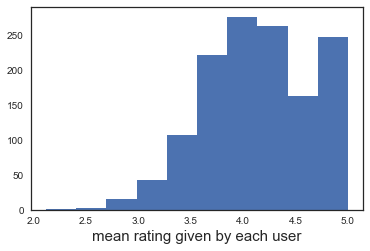

In [9]:
average_rank = df["overall"].mean()

fig = plt.figure(figsize=(10,10))

mean_rating_of_user = df.groupby('reviewerID').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(322)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each user', fontsize=15)

plt.tight_layout()
plt.show()


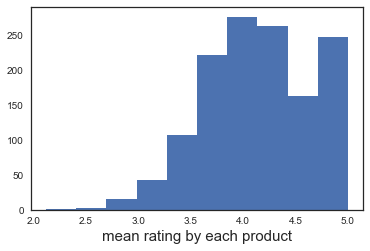

In [10]:
average_rank = df["overall"].mean()
fig = plt.figure(figsize=(10,10))

# mean ratings from each user
mean_rating_of_item = df.groupby('product').apply(lambda x: x['overall'].mean())
ax = fig.add_subplot(322)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating by each product', fontsize=15)

plt.tight_layout()
plt.show()


In [11]:
def train_by_df(from_model, train_df, dev_df, test_df, num_user, num_item, debug = True, implicit_df = None):
    print (80 * "=")
    print ("INITIALIZING")
    print( 80 * "=")
    config = from_model.Config()
    config.n_items = num_item 
    config.n_users = num_user
    config.maxday_cat_code = max(train_df["TDayCat"].values)
    
    if not os.path.exists('data\\weights\\'):
        os.makedirs('.\\data\\weights\\')

    with tf.Graph().as_default():
        print ("Building model...",)
        start = time.time()
        model = from_model.RecommandationModel(config) 
        

        init = tf.global_variables_initializer()

        saver = None if debug else tf.train.Saver()

        with tf.Session() as session:
            #recommand.session = session
            session.run(init)

            print( 80 * "=")
            print( "TRAINING")
            print( 80 * "=")
            model.fit(session, saver, train_df, dev_df) #, implicit_df)
            print("Done!")
            print ("took {:.2f} seconds\n".format(time.time() - start))
            
            if not debug:
                print (80 * "=")
                print ("TESTING")
                print( 80 * "=")
                print ("Restoring the best model weights found on the dev set")
                #saver.restore(session, model.config.weight_filename)
                print ("Final evaluation on test set",)
                mean_rank = train_df["overall"].mean() #global rank mean
        
                mean_u_day = getMeanDaybyUser(train_df)
                test_loss = model.run_epoch(session, train_df, mean_rank, mean_u_day, test_df) 
                
                print ("- test l2 loss: {:.5f}", test_loss)

                print ("Done!")
                
                return test_loss

In [12]:
def train_by_df_timeVCDplus(from_model, train_df, dev_df, test_df, num_user, num_item, debug = True, implicit_df = None):
    print (80 * "=")
    print ("INITIALIZING")
    print( 80 * "=")
    config = from_model.Config()
    config.n_items = num_item 
    config.n_users = num_user
    config.maxday_cat_code = max(train_df["TDayCat"].values)
    
    if not os.path.exists('data\\weights\\'):
        os.makedirs('.\\data\\weights\\')

    with tf.Graph().as_default():
        print ("Building model...",)
        start = time.time()
        model = from_model.RecommandationModel(config) 
        

        init = tf.global_variables_initializer()

        saver = None if debug else tf.train.Saver()

        with tf.Session() as session:
            #recommand.session = session
            session.run(init)

            print( 80 * "=")
            print( "TRAINING")
            print( 80 * "=")
            model.fit(session, saver, train_df, dev_df, implicit_df)
            print("Done!")
            print ("took {:.2f} seconds\n".format(time.time() - start))
            
            if not debug:
                print (80 * "=")
                print ("TESTING")
                print( 80 * "=")
                print ("Restoring the best model weights found on the dev set")
                #saver.restore(session, model.config.weight_filename)
                print ("Final evaluation on test set",)
                mean_rank = train_df["overall"].mean() #global rank mean
        
                mean_u_day = getMeanDaybyUser(train_df)
                test_loss = model.run_epoch(session, train_df, mean_rank, mean_u_day, test_df, implicit_df) 
                
                print ("- test l2 loss: {:.5f}", test_loss)

                print ("Done!")
                
                return test_loss

In [13]:
loss_dict={}
loss_dict["Base"] = get_df_base_loss(train_df, dev_df, test_df)[2]

mean is:  4.16275031832


This is the whole matrix factorization model(timeVCD++) for recommender system:
\begin{align}
\hat{r}_{ui} = \mu + b_i(t_{ui}) + b_u(t_{ui}) + q_i^T\left(p_u(t_{ui}) + |R(u)|^{-\frac{1}{2}}\sum_{j \in R(u)}y_j\right) \\
p_{uk}(t) = p_{uk} + \alpha_{uk}{\cdot}dev_u(t) + p_{uk,t}  \\
b_i(t_{ui}) = b_i + b_{i,Bin(t)}\\
b_u(t_{ui}) = b_u + \alpha_{u}{\cdot}dev_u(t) + b_{u,t}
\end{align}

In [14]:
loss_dict["TALL"] = train_by_df_timeVCDplus(tall, train_df, dev_df, test_df, num_user, num_item, debug = False, implicit_df = implicit_train_df )

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.976541102615
new best dev loss!: 0.976541102615
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.959576310221
new best dev loss!: 0.959576310221
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.944252549187
new best dev loss!: 0.944252549187
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.9301483529
new best dev loss!: 0.9301483529
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.916738319067
new best dev loss!: 0.916738319067
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 6 out of 30
Evaluating on dev set
curr

In [15]:
loss_dict["VTDay"] = train_by_df(tdiuvtday, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.979636235312
new best dev loss!: 0.979636235312
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.969056785398
new best dev loss!: 0.969056785398
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.959288434435
new best dev loss!: 0.959288434435
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.950121466661
new best dev loss!: 0.950121466661
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.941082364206
new best dev loss!: 0.941082364206
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 6 out of 30
Evaluating on dev set


In [16]:
loss_dict["IUDay"] = train_by_df(tdiutday, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.969746156729
new best dev loss!: 0.969746156729
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.952645307891
new best dev loss!: 0.952645307891
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.935266318829
new best dev loss!: 0.935266318829
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.917760909937
new best dev loss!: 0.917760909937
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.90015991244
new best dev loss!: 0.90015991244
New best dev UAS! data\weights\recommanding_with_IU_time_drifting.weight

Epoch 6 out of 30
Evaluating on dev set
cu

In [17]:
loss_dict["UserDay"] = train_by_df(tdutday, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.96939753366
new best dev loss!: 0.96939753366
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.952635728167
new best dev loss!: 0.952635728167
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.936396631873
new best dev loss!: 0.936396631873
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.920586080558
new best dev loss!: 0.920586080558
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.905252278311
new best dev loss!: 0.905252278311
New best dev UAS! data\weights\recommanding_with_user_day_drifting.weight

Epoch 6 out of 30
Evaluating on dev s

In [18]:
loss_dict["UserTime"] = train_by_df(tdut, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.969779383866
new best dev loss!: 0.969779383866
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.952998403647
new best dev loss!: 0.952998403647
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.936714438805
new best dev loss!: 0.936714438805
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.920796289856
new best dev loss!: 0.920796289856
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.905248554384
new best dev loss!: 0.905248554384
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 6 out of 30
Evaluating o

In [19]:
loss_dict["ItemTime"] = train_by_df(tdit, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.968847185341
new best dev loss!: 0.968847185341
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.951341270862
new best dev loss!: 0.951341270862
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.934542407394
new best dev loss!: 0.934542407394
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.918226948954
new best dev loss!: 0.918226948954
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.902410005237
new best dev loss!: 0.902410005237
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 6 out of 30
Evaluating o

In [20]:
loss_dict["Vector"] = train_by_df(tdv, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.968854225262
new best dev loss!: 0.968854225262
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.951522436726
new best dev loss!: 0.951522436726
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.934585227336
new best dev loss!: 0.934585227336
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.918166110914
new best dev loss!: 0.918166110914
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.902079888306
new best dev loss!: 0.902079888306
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 6 out of 30
Evaluating o

In [21]:
loss_dict["Biasonly"] = train_by_df(tdb, train_df, dev_df, test_df, num_user, num_item, debug = False)

INITIALIZING
Building model...
TRAINING
Epoch 1 out of 30
Evaluating on dev set
current DEV loss =  0.971770967862
new best dev loss!: 0.971770967862
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 2 out of 30
Evaluating on dev set
current DEV loss =  0.957256770692
new best dev loss!: 0.957256770692
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 3 out of 30
Evaluating on dev set
current DEV loss =  0.943465730933
new best dev loss!: 0.943465730933
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 4 out of 30
Evaluating on dev set
current DEV loss =  0.930292408491
new best dev loss!: 0.930292408491
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 5 out of 30
Evaluating on dev set
current DEV loss =  0.917875893182
new best dev loss!: 0.917875893182
New best dev UAS! data\weights\recommanding_with_user_time_drifting.weight

Epoch 6 out of 30
Evaluating o

(0.65, 1.0402628908705278)

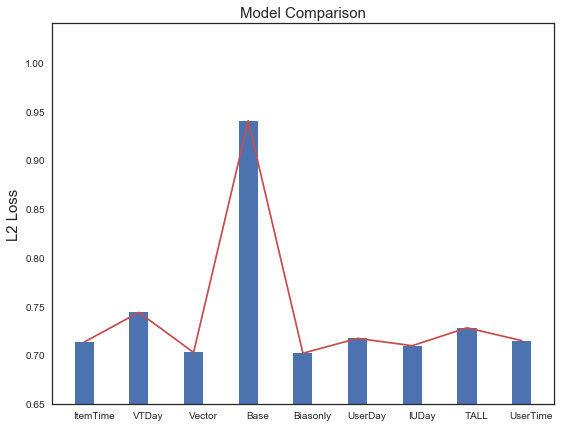

In [22]:
N = len(loss_dict.values())
x = list(loss_dict.values()) 

ind = np.arange(N)  
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(9, 7))
g1 = ax.bar(ind, x, width, color='b')
g2 = ax.plot(x, 'r')

# add some text for labels, title and axes ticks
ax.set_ylabel('L2 Loss', fontsize=15)
ax.set_title('Model Comparison', fontsize=15)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(list(loss_dict.keys())) 
ax.tick_params(labelsize=10)
ax.set_ylim([0.65, max(x) + 0.1])


In [23]:
print(loss_dict)

{'ItemTime': 0.71331992276074019, 'VTDay': 0.74377670059653789, 'Vector': 0.70265239316196371, 'Base': 0.94026289087052783, 'Biasonly': 0.70189000991820594, 'UserDay': 0.71707035456347556, 'IUDay': 0.70957796917096472, 'TALL': 0.72793237761622298, 'UserTime': 0.71485151710836048}
